# Machine Learning Workshop Practice : Part II

_[Edit: This is now the complete version with all the answers of the practice]_  
  
This part will show you how to:
1. build your model using keras 
1. optimize your model using keras 
1. explore a famous classification application: handwritten digit recognition.

## Packages
 
- [tensorflow](https://www.tensorflow.org) an open source platform developped by Google that has efficient computation structures (**we use 2.X version**).
- [keras](https://keras.io/) is a high-level neural networks API that can run on different backends such as Tensorflow.
- [numpy](http://www.numpy.org) is a fundamental package for scientific calculations.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- [pickle](https://docs.python.org/3/library/pickle.html) is a library for serializing and de-serializing of Python objects.
- [skimage](https://scikit-image.org) is a collection of algorithms for image processing.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from skimage import data, color
from skimage.transform import resize
from skimage import io

Using TensorFlow backend.


In [2]:
# Define variables
NUM_CLASSES = 10  # number of outputs (they are digits!)
BATCH_SIZE = 128  # split the training data into smaller groups to fit with computer memory during training
EPOCHS = 10       # number of training iterations (where one iteration has seen all batches)

## Discover the dataset

The **[MNIST](http://yann.lecun.com/exdb/mnist/)** dataset is used in this example.

The MNIST is a database of handwritten digits. It has **60,000 examples as a training set and 10,000 examples as a test set**.
All the digits have been size-normalized and centered in a fixed-size
Therefore there is **no need to do any preprocessing**.

Since Tensorflow 2.X is used in this example we can download it with keras's helper script. 

In [3]:
# load the MNIST data set, which already splits into train and test sets for us
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Each dataentry is represented as a matrix of size **(28x28)**.
Where each element of the matrix is a brightness level of corresponding pixel.
MNIST is a multiclass classification problem of **10 classes**.

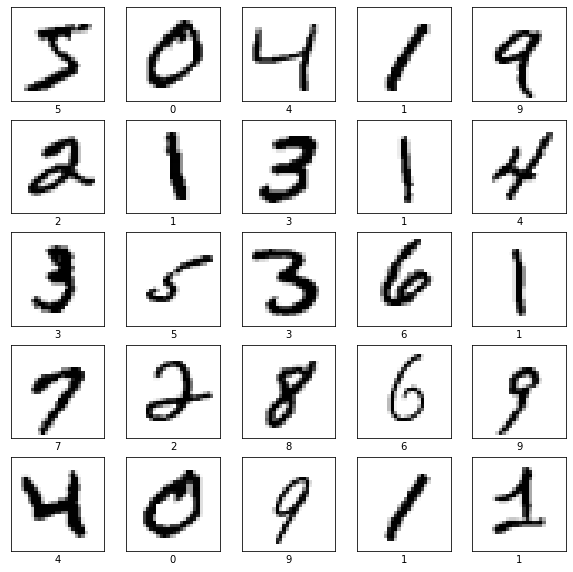

In [4]:
# plot 25 first training examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show();

In [5]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is grayscale, we only have a single channel - RGB colour images would have 3
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)
input_shape = x_train.shape[1:]
print("One Image shape: ", input_shape)

One Image shape:  (28, 28, 1)


For numerical stability let's rescale data from range (0,255) to (0,1)

In [6]:
# rescale data range
x_train = x_train / 255
x_test = x_test / 255

In [7]:
print("Total train: ", y_train.shape[0])
print("Total test: ", y_test.shape[0])
print("Classes: ", np.unique(y_train).shape[0])

Total train:  60000
Total test:  10000
Classes:  10


## Convolutional Neural Network

Now let's implement a convolutional neural network (CNN) that recognizes images !

Here is a CNN's type of architecture:
![CNN Architecture](https://res.mdpi.com/information/information-07-00061/article_deploy/html/images/information-07-00061-g001.png)

Check out [this]( http://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/)
tutorial to learn more about the different layers

What we want from our model is:
- to feed in a handwritten digit image,
- to ouput the most likely of the 10 possible labels.

Recall that we are working with multiclass classification, thus we would like our model to output a discrete probability distribution over all ten classes.
Our true labels is to be represented in a form of a target distribution where all probabilities are zero except target class (one-hot encoding).

Having both of the distributions, we could calculate our loss function as the cross entropy:
$$
L = - \sum_{i=1}^{N} \sum_{j=1}^{10}p_{ij} \log(\hat{p}_{ij})
$$

Class prediction could be easly calculated from equation:
$$
\hat{y}_i = \mathop{argmax}\limits_{j} \hat{p}_{ij}
$$

## Define the model structure

In [8]:
# Transform all output to one-hot-encoding
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [9]:
# see what is one hot encoding:
i = 5
print("Label : ", y_train[i])
print("One hot encoding : ", y_train_ohe[i])

Label :  2
One hot encoding :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))  # add a Dense layer of size 1000 and ReLU activation
model.add(Dense(NUM_CLASSES, activation='softmax'))  # add a Dense layer of size 'output_size' and softmax activation

In [11]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Fun fact: Even on this relatively small model we are expecting accuracy to be around 99%.  

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1025000   
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

**Now we have determined the structure of our network, we are ready to train it !**

## Model training

**Let's learn the models parameters:** 

The fit function performs:
- forward propagation
- cross entropy loss
- backward propagation
- update parameters with Adam optimization

_(It may take up to 10 minutes to train...  
We trained it for you from this code - see the epcohes below - you can simply load the saved model with: `load_model('digit_model.h5')`. Choose to uncomment and run the desired parts in the next cells below)_

In [47]:
# history = model.fit(x_train, y_train_ohe,
#           batch_size=BATCH_SIZE,
#           epochs=EPOCHS,
#           verbose=1,
#           validation_data=(x_test, y_test_ohe))

In [37]:
# #save model and history

# model.save('digit_model.h5')  # creates a HDF5 file 'digit_model.h5'

# with open('history.pkl', 'wb') as fp:
#     pickle.dump(history, fp)

In [26]:
# load model and history

model = load_model('digit_model.h5') # returns the trained model

with open('history.pkl', 'rb') as fp:
    history = pickle.load(fp)

## Model evaluation

In [27]:
score = model.evaluate(x_test, y_test_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.031922926600565185
Test accuracy: 0.9918000102043152


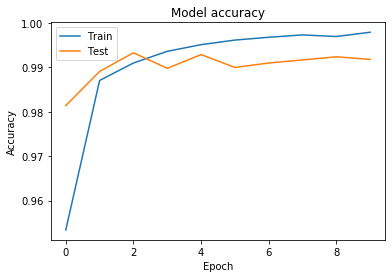

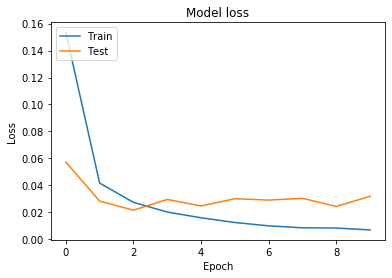

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model prediction

In [29]:
# predict all test dataset
prediction = model.predict(x_test)

output:  [1.0000000e+00 1.6427519e-10 3.2833128e-10 5.5333928e-13 7.2353462e-13
 4.5522532e-09 4.2484363e-10 1.9246871e-09 9.3433075e-09 1.0325315e-10]
predicted label:  0


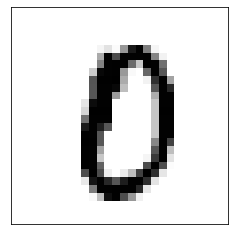

In [32]:
# plot some of these predictions
i = 55
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_test[i].reshape((x_test[i].shape[0],x_test[i].shape[1])), cmap=plt.cm.binary)
print("output: ", prediction[i])
print("predicted label: ", np.argmax(prediction[i]))

Predicted label:  6


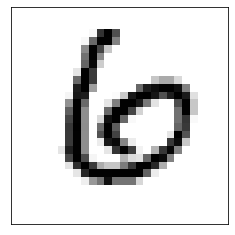

In [31]:
# How to predict a single image:
i = 11

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_test[i].reshape((x_test[i].shape[0],x_test[i].shape[1])), cmap=plt.cm.binary)

# prediction: 
# Because the model has been trained on batches, the size was extended to take a batch index
# we need to reshape the input size to fit with the learned structure

new_x = np.expand_dims(x_test[i], axis=0)
pred = model.predict_classes(new_x)
print("Predicted label: ", int(pred))

## Try your own image !!

Your task, should you choose to accept it, is to create your own handwritten digit example.
We suggest to use standard image redactors for the task (Paint for Windows; GIMP for Unix)

Instructions:
1. create a square image (recall that we use img dimensions of 28*28 so keep a low resolution for consistency)
1. use painting tools for writing a digit
1. save your image to img_digit folder in this workspace
1. change IMG_PATH constant in the following cell to a path to your image

For the demonstration purpose we created such an image.

Own image (of size 200*200px):
<img src="img_digit/own_image.png" style="width:100px;height:100px;">

In [33]:
# make a new prediction
IMG_PATH = "img_digit/own_image.png"  # change to your image path

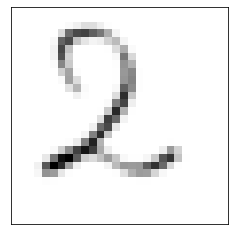

In [34]:
new_img = 1 - color.rgb2gray(io.imread(IMG_PATH))
# resize image to fit the model
new_img = resize(new_img, (x_test[i].shape[0],x_test[i].shape[1]), anti_aliasing=True)

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(new_img, cmap=plt.cm.binary)

In [35]:
# prediction: 
# Because the model has been trained on batches, the size was extended to take a batch index
# we need to reshape the input size to fit with the learned structure
new_x = np.expand_dims(new_img, axis=0)
new_x = np.expand_dims(new_x, axis=3)

pred = model.predict_classes(new_x)
print("Predicted label: ", int(pred))

Predicted label:  2


**Congratulations in finishing this notebook, this is    THE END OF PART II**


Tutotial reference: http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/